In [1]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform

#### Get audio vector and inital tempo estimation

In [2]:
path = '../audio/pain_factor-8_seconds-02-pull-88-117.mp3'
fs = 16000
loader = estd.MonoLoader(filename=path, sampleRate= fs)
tempo_estimation_algo = estd.PercivalBpmEstimator()
audioInput = loader()
bpm = tempo_estimation_algo(audioInput)
print(bpm)

90.6661148071289


#### Compute spectrogram and 2-band energy

In [17]:
## var init
beat_duration = (60/bpm)*fs  ## in samples
frame_size = int(round(beat_duration/32))
hop_size = round(frame_size/2)
fft_size = int(np.power(2, np.ceil(np.log2(frame_size))))
padding_size = fft_size - frame_size
band1 = (1, 3000)
band2 = (5443, 7619)
energy_threshold = 5000.0    ## the 1st energy_ratio value above this will be understood as first note in audio file

## get necessary Essentia algorithms
window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann', zeroPadding = padding_size)
fft_algo = estd.FFT(size = fft_size)
energy1_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band1[0], stopCutoffFrequency=band1[1])
energy2_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band2[0], stopCutoffFrequency=band2[1])

spectrogram = []
db_spectrogram = []
print('Frame Size:', frame_size)
print('FFT Size:', fft_size)
print('Padding length:', padding_size)

first_note_flag = -1
for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
    ## spectrogram
    windowed_frame = window_algo(frame)
    mX = abs(fft_algo(windowed_frame))
    mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
    dbX = 20 * np.log10(mX)
    spectrogram.append(np.array(mX))
    db_spectrogram.append(np.array(dbX))
    
    ## energies and first note location
    energy1 = energy1_algo(mX)
    energy2 = energy2_algo(mX)
    energy_ratio = energy1/energy2
    if (first_note_flag == -1) and (energy_ratio > energy_threshold):
        first_note_flag = index
        print("Found first note for frame with E1=", energy1, ", E2=", energy2, ", and E1/E2=", energy_ratio)
    
spectrogram = np.array(spectrogram)
db_spectrogram = np.array(db_spectrogram)
print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)

Frame Size: 331
FFT Size: 512
Padding length: 181
Found first note for frame with E1= 0.3810136914253235 , E2= 7.605959399370477e-05 , and E1/E2= 5009.410008905108
Spectrogram done. Size is (axis1, axis2): (1453, 257)


#### Plot Spectrogram (for visual feedback only)

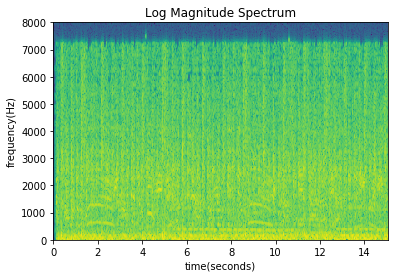

In [18]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [19]:
## time(sec) of found first note
print('First note found at time:', first_note_flag*hop_size/fs, 'seconds')

First note found at time: 7.584125 seconds


In [20]:
first_note_flag

731

In [21]:
ref_ASM = squareform(pdist(spectrogram))

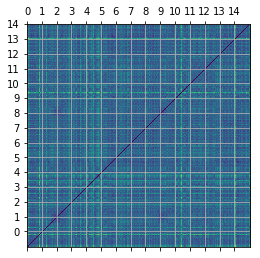

In [22]:
labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

In [23]:
bar_candidates = np.multiply(64, list(range(2, 12)))

In [24]:
def segment_diagonal(diagonal, bar_length):
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

In [34]:
diagonals = {}
for bar in bar_candidates:
    diagonals[bar] = {}
    numb_diagonals = int(ref_ASM.shape[0]/bar)
    for i in range(1, numb_diagonals):
        diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
        diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
